<h2>Linear  algebra</h2>

<h2>General least squares</h2>

[ 8.39748692 -0.08469547] 5648.229131640167
2
[0.05105538 0.98173868] 82.96618664651776
2
[ 8.39748692e+00 -4.44331250e-03] 5649.6500910384975
2
[57.95867148  9.557507  ] 99.47228274990205
2


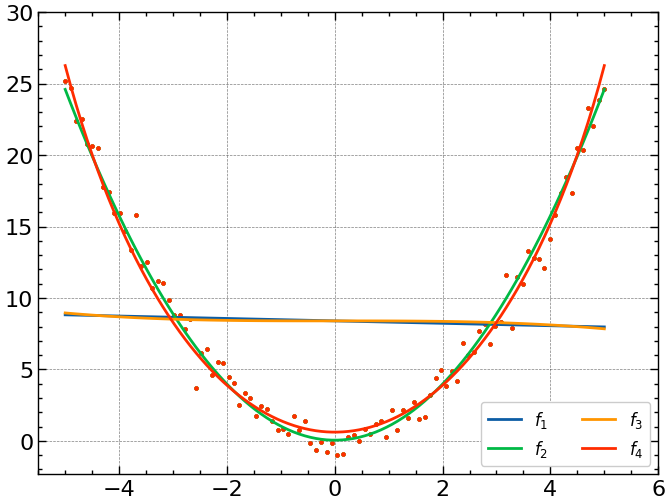

In [ ]:
import numpy as np
from scipy import linalg

def householder_op(v):
    """
        Returns Householder operator for the vector v
    """
    # print('===========')
    N = len(v)
    e_1 = np.zeros(N)
    e_1[0] = 1

    # print(f'{e_1=}')

    w = linalg.norm(v)*e_1 - v

    # print(f'{w=}')
    # print(f'{np.array([w]).T=}')
    # print(f'{np.array([w]).T@np.array([w])=}')

    P = np.eye(N, N) - 2/np.dot(w, w) * np.array([w]).T@np.array([w])
    # print(P)
    
    # print('===========')
    return P


def ur_decomposition(A):
    """
        Find decomposition A = UR, U - orthogonal, R - upper triangular
    """
    P_list = []
    A_copy = np.copy(A)
    eps = 1e-8

    for i in range(min(A.shape[0], A.shape[1])):
        P_list.append(np.block([[np.eye(i), np.zeros((i,A_copy.shape[0]-i))], [np.zeros((A_copy.shape[0]-i,i)),householder_op(A_copy[i:, i])]]))
        A_copy = P_list[-1]@A_copy

    P_prod = P_list[0]
    for P in P_list[1:]:
        P_prod = P@P_prod

    # print(f'R - A_copy:  {P_prod@A-A_copy}')
    # R = P_prod@A

    R = A_copy

    return P_prod.T, R, P_list


def is_orthogonal(U):
    """
        Checks if U is orthogonal
    """
    eps = 1e-5
    flag = True
    flag = flag and np.abs(linalg.det(U)) - 1 < eps
    for i in range(U.shape[0]):
        for j in range(i, U.shape[0]):
            if i == j:
                flag = flag and np.dot(U[:,i], U[:, j]) - 1 < eps
            else:
                flag = flag and np.dot(U[:,i], U[:, j]) < eps
    return flag


def least_squares(X: list, Y: list, G: list):
    """
        Solves least squares problem for arbitrary set of functions G
        with Householder operator method
    """
    # print("======")
    A = np.array([[g(x) for g in G] for x in X])

    U, R, _ = ur_decomposition(A)
    
    # print(f'{U.T@A=}')
    # print(f'U unitary: {is_orthogonal(U)}')
    # print(f'R = {R}')
    # print(f'UR = {U@R}')
    

    # print(f'Y norm before: {linalg.norm(Y)}')
    v = U.T@Y
    # print(f'Y norm after: {linalg.norm(v)}')

    size_non_zero = R.shape[1]
    R_sq = R[:size_non_zero,:]
    v_upper = v[:size_non_zero]
    w = v[size_non_zero:]

    # print(f'{R_sq=}')

    alpha = linalg.solve(R_sq, v_upper)

    # print(f'{R_sq=}, {v_upper=}, {alpha=}, {v=}, {w=}')

    residue = linalg.norm(w)**2


    # print("======")
    return alpha, residue


# A = np.array([[1, -1, 1], 
#               [2, -1, 0], 
#               [2, 0, 1]])

# A = np.array([[1, -1, 1], 
#               [2, -1, 0], 
#               [2, 0, 1],
#               [3, 4, 5]])

#

# eigval, eigvec = linalg.eig(A)
# eigval*eigvec[:,0] # element-wise multiplication
# [print(linalg.norm(eigval[i]*eigvec[:,i] - A@eigvec[:,i])) for i in range(3)] # matrix multiplication

#


#   Least squares test

import matplotlib.pyplot as plt
from scipy.stats import norm
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

def make_cos_n(n):
    def cos_n(x):
        return np.cos(n*x)
    return cos_n

def make_sin_n(n):
    def sin_n(x):
        return np.sin(n*x)
    return sin_n

g_list = [
        [lambda x: 1, lambda x: x,],

        [lambda x: 1, lambda x: x**2,],

        [lambda x: 1, lambda x: x**3,],

        # [lambda x: np.sin(x), lambda x: 1,],

        # [lambda x: 1, lambda x:  np.cos(x), lambda x: np.sin(x),],

        # [lambda x: 1, lambda x: x, lambda x: x**2,],

        # [lambda x: np.exp(x), lambda x: 1],
        # [lambda x: np.log(x+0.001), lambda x: 1],
        
        # [make_cos_n(n) for n in range(8)] + [make_sin_n(n) for n in range(1, 9)],
        # [make_cos_n(n) for n in range(20)] + [make_sin_n(n) for n in range(1, 21)],
        [lambda x: 1, lambda x: -np.sqrt(36-x**2)]     

]

X = np.linspace(0, 5, 100)
s = norm.rvs(size = X.size, scale=1)
Y = X**2 + s

X = np.linspace(-5, 5, 100)
s = norm.rvs(size = X.size, scale=1)
Y = X**2 + s

# X = np.linspace(-5, 5, 100)
# s = norm.rvs(size = X.size, scale=0.5)
# Y1 = np.sqrt(25-X**2) + s
# Y2 = -np.sqrt(25-X**2) + s
# Y = np.concatenate((Y1, Y2))
# X = np.concatenate((X,X))

k = 0
for g_set in g_list:
    alpha, res = least_squares(X, Y, g_set)
    print(alpha, res)

    print(len(g_set))

    def approximant(x):
        res = 0
        for i in range(len(g_set)):
            res += alpha[i]*g_set[i](x)
        return res

    approximant = np.vectorize(approximant)

    plot_arg = np.linspace(-5,5,100)
    plt.scatter(X, Y, s=5)
    plt.plot(plot_arg, approximant(plot_arg), label=f'$f_{k+1}$')
    plt.legend(loc='lower right', ncol=2, fontsize=12)
    plt.ylim(top=30)
    plt.xlim(right=6)

    k+=1
plt.savefig('images/least_sq.png', dpi=200)